In [3]:
# use observed streamflow data to evaluate model outputs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import pyviscous

sys.path.append('../MOASMO_support/')
from mo_evaluation import main_read_CTSM_streamflow, read_CAMELS_Q_and_to_xarray, get_modified_KGE, get_RMSE, get_max_abs_error

# Load observed streamflow

In [4]:
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

outpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_evaluation'
os.makedirs(outpath, exist_ok=True)
outfile = f'{outpath}/obs_streamflow.nc'

In [5]:
ref_q_name = 'Runoff_cms'
ref_q_date = 'Date'
if os.path.isfile(outfile):
    ds_q_obs = xr.load_dataset(outfile)
else:
    ds_q_obs = [read_CAMELS_Q_and_to_xarray(file, ref_q_date, ref_q_name) for file in df_info['file_obsQ']]
    ds_q_obs = xr.concat(ds_q_obs, dim='lndgrid')
    ds_q_obs.to_netcdf(outfile)
    
ds_q_obs

<xarray.Dataset>
Dimensions:     (time: 12784, lndgrid: 627)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Dimensions without coordinates: lndgrid
Data variables:
    Runoff_cms  (lndgrid, time) float64 18.55 18.12 17.7 ... 79.57 69.66 61.16

# For each simulation, perform the evaluation and save the outputs

In [6]:
inpath0 = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs'
inpath_default = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_default'
fsurdat = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/sfcdata/surfdata_CAMELSandTDX_areabias_fix.simp0.001.level1_hist_78pfts_CMIP6_simyr2000_HAND_4_col_hillslope_geo_params_nlcd_bedrock.nc'

clm_q_name = 'QRUNOFF'
date_start = '2004-10-01'
date_end = '2009-09-30'
minfilenum = 7

ngrid = len(ds_q_obs.lndgrid)
niter = 200

for t in range(-1, niter):
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    if os.path.isfile(outfile_metric):
        continue

    kge = np.nan * np.zeros(ngrid)
    maxabserror = np.nan * np.zeros(ngrid)
    rmse = np.nan * np.zeros(ngrid)
    # infiles
    if t >= 0:
        CTSMfilelist = glob.glob(f'{inpath0}/iter0_trial{t}/lnd/hist/*h1*.nc')
    else:
        CTSMfilelist = glob.glob(f'{inpath_default}/lnd/hist/*h1*.nc')
    
    CTSMfilelist.sort()

    if len(CTSMfilelist)<minfilenum:
        print('Too few files for trial', t)
    else:
        # load variable
        ds_simu = main_read_CTSM_streamflow(fsurdat, CTSMfilelist, date_start, date_end, clm_q_name)
    
        # evaluation
        ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
        ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))
    
        ds_q_obs[ref_q_name] = ds_q_obs[ref_q_name].where(ds_q_obs[ref_q_name] >= 0, np.nan)
        ds_simu[clm_q_name] = ds_simu[clm_q_name].where(ds_simu[clm_q_name] >= 0, np.nan)
            
        for l in range(ngrid):
            d1 = ds_q_obs[ref_q_name].sel(lndgrid=l).values
            d2 = ds_simu[clm_q_name].sel(lndgrid=l).values
            kge_q = get_modified_KGE(obs=d1, sim=d2)
            kge[l] = kge_q
    
            rmse_q = get_RMSE(obs=d1, sim=d2)
            rmse[l] = rmse_q
    
            d1 = ds_q_obs[ref_q_name].sel(lndgrid=l).groupby('time.month').mean().values
            d2 = ds_simu[clm_q_name].sel(lndgrid=l).groupby('time.month').mean().values
            maxabserror_q = get_max_abs_error(d1, d2)
            maxabserror[l] = maxabserror_q

    df_metric = pd.DataFrame({'KGEmod': kge, 'rmse':rmse, 'maxabserror':maxabserror})
    # df_metric.to_csv(outfile_metric, index=False)

# Load all parameter values and all metrics to perform sensitivity analysis

## Load parameters

In [7]:
nparam = 27
params = np.nan * np.zeros([niter+1, nparam])

for i in range(-1, niter):
    if i>=0:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/paramset_iter0_trial{i}.pkl'
    else:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/all_default_parameters.pkl' # -1: default paramters
        
    df_param = pd.read_pickle(file)
    va = df_param['Value'].values
    for j in range(nparam):
        params[i+1, j]=np.mean(va[j])

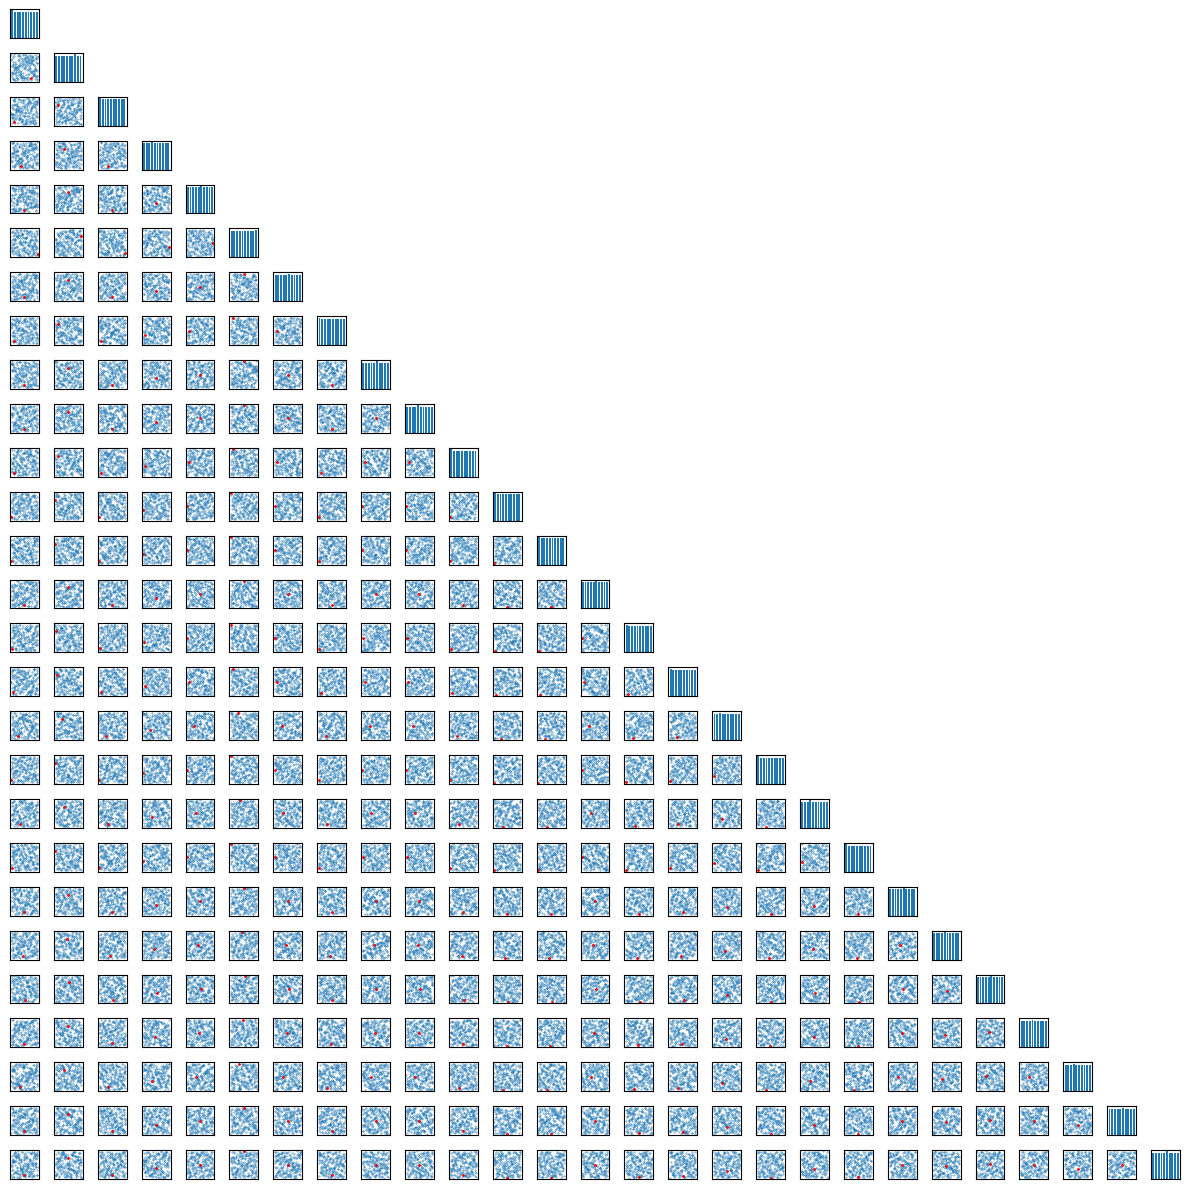

In [8]:
# Scatter plots and histograms between all parameter pairs

fig, axs = plt.subplots(nparam, nparam, figsize=[12, 12])

for i in range(nparam):
    for j in range(nparam):
        ax = axs[i, j]
        
        if j>i:
            ax.axis('off')
            
        elif j==i:
            ax.hist(params[:,i], rwidth=0.7)
            
            # Hide X and Y axes label marks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

            # Hide X and Y axes tick marks
            ax.set_xticks([])
            ax.set_yticks([])
            
        else:
        
            ax.scatter(params[:,i], params[:,j], 0.1)
            ax.scatter(params[0,i], params[0,j], 1, color='r') # default parameters

            # Hide X and Y axes label marks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

            # Hide X and Y axes tick marks
            ax.set_xticks([])
            ax.set_yticks([])
        
plt.tight_layout()
plt.show()

## Load evaluation metrics

In [9]:
kge = np.nan * np.zeros([niter+1, ngrid])
for t in range(-1, niter): # -1 is default
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    df_metric = pd.read_csv(outfile_metric)
    kge[t+1, :] = df_metric['KGEmod'].values

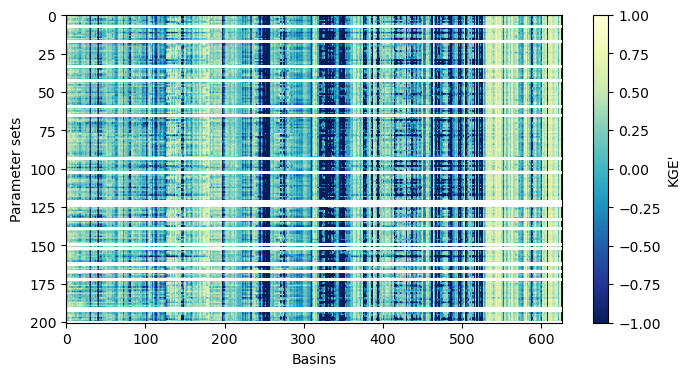

In [10]:
fig = plt.figure(figsize=[8, 4])            
plt.imshow(kge, aspect='auto', cmap='YlGnBu_r', vmin=-1, vmax=1)
plt.xlabel('Basins')
plt.ylabel('Parameter sets')
plt.colorbar(label="KGE'")
plt.show()

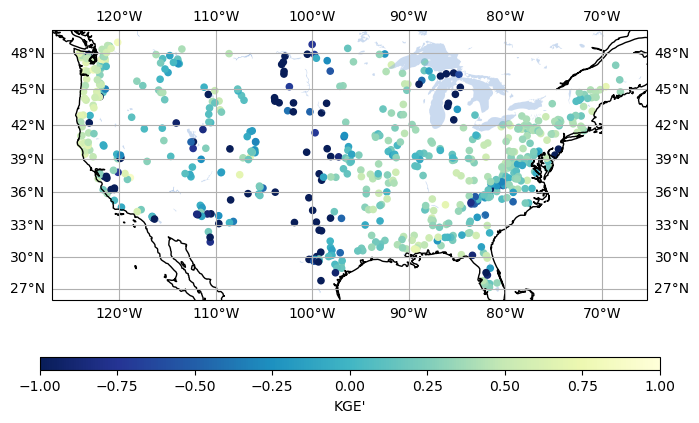

In [33]:
lat_cen = df_info['lat_cen'].values
lon_cen = df_info['lon_cen'].values

default_kge = kge[0, :]

# Create a new figure with a specific size
plt.figure(figsize=(10, 5))

# Create a GeoAxes in the tile's projection
ax = plt.axes(projection=ccrs.Miller())

# Add coastlines to the map
ax.coastlines()

ax.add_feature(cfeature.LAKES, alpha=0.5)  # Adds lakes, including the Great Lakes, with some transparency

p = ax.scatter(lon_cen, lat_cen, 20, default_kge, cmap='YlGnBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(p, ax=ax, orientation='horizontal', aspect=50, shrink=0.8, label="KGE'")

# Set the extent (longitude, latitude) for the map
# ax.set_extent([-180, 180, -90, 90])

# Add a gridliner
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Display the plot
plt.show()

plt.show()

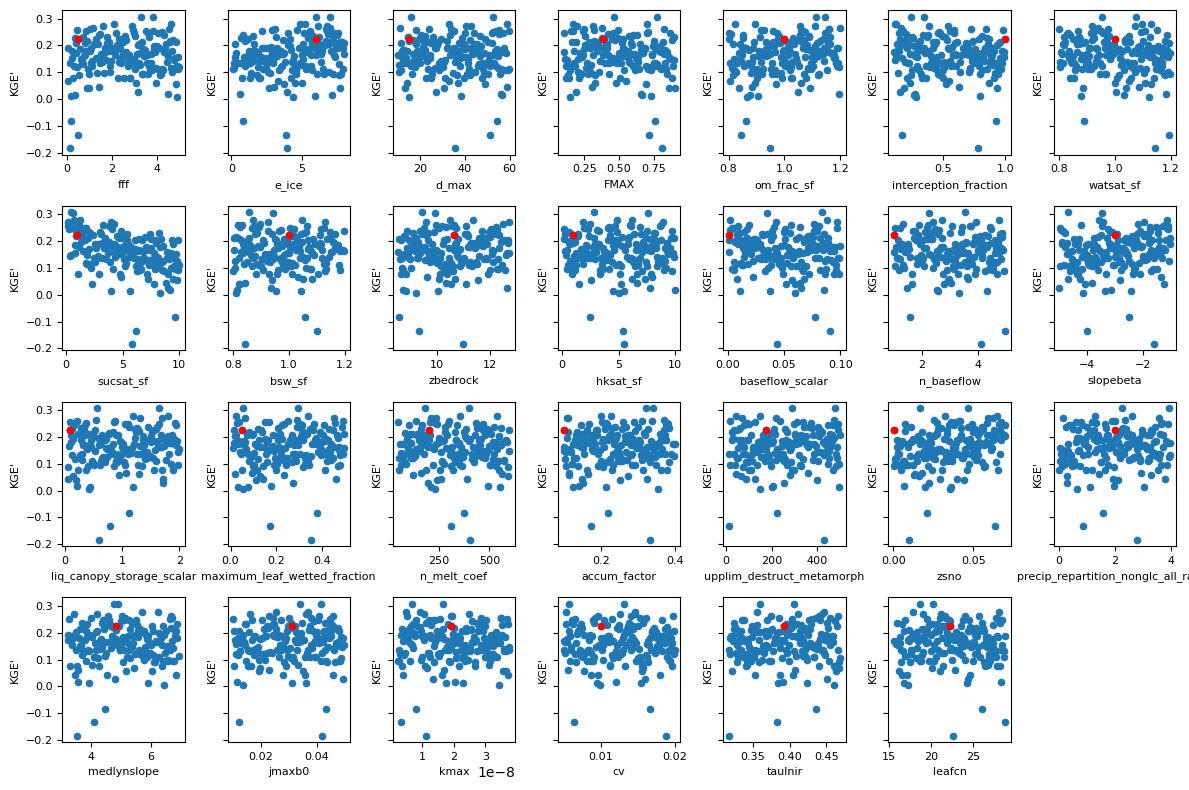

In [26]:
# plot inputs-output
fig, axs = plt.subplots(4, 7, figsize=(12, 8), sharey=True)
axs = axs.flatten()

kge_mean = np.nanmedian(kge, axis=1)
paramanmes = df_param['Parameter'].values

for i in range(nparam):
    axs[i].scatter(params[:,i], kge_mean, 20)
    axs[i].scatter(params[0,i], kge_mean[0], 20, color='r')
    axs[i].set_xlabel(paramanmes[i], fontsize=8)
    axs[i].set_ylabel("KGE'", fontsize=8)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

axs[i+1].axis('off')

plt.tight_layout()
plt.show()

In [30]:
np.nanmax(np.nanmedian(kge, axis=1))

0.3075351589032655

## conduct sensivitiy analysis

### Calculate the first-order sensitivity index

In [45]:
# this is very slow, so data is saved and another script is used to estimate sensitivities
# %%capture 
# # avoid the too many printouts from pyviscous

# sens_indx_first = np.nan * np.zeros([nparam, ngrid])
# sens_indx_total = np.nan * np.zeros([nparam, ngrid])

# # for i in range(0, ngrid, 100):
# for i in range(1):
#     x = params
#     y = kge[:,i]
#     ind = ~np.isnan(y)
#     x, y = x[ind,:], y[ind]
#     y = y[:,np.newaxis]
    
#     for xIndex in range(nparam): 
#         sens_indx_first[xIndex, i], gmcm_first = pyviscous.viscous(x, y, xIndex, 'first', MSC='AIC',verbose=False) 
#         sens_indx_total[xIndex, i], gmcm_total = pyviscous.viscous(x, y, xIndex, 'total', MSC='AIC',verbose=False)     

In [52]:
# save data for sensitivity analysis
df_param = df_param[['Type','Process','PPE_DailyQ_Rank','Parameter','Default',
                     'Lower','Upper','LowUp_vsPPE','Source','Binding']]
np.savez_compressed('SA_data.npz',df_param=df_param, df_info=df_info, 
                    params=params, paramnames=paramanmes, kge=kge)